# MULTIHEAD ATTENTION

In [1]:
import numpy as np
import polars as pl
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm import tqdm

import re
from typing import List, Dict, Any, Tuple, Optional, Mapping, Set, Self, NamedTuple, TypedDict

In [2]:
def fix_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

# BUILD TRANSFORMER

In [3]:
class RMSNorm(nn.Module):
    def __init__(
        self,
        embedding_size: int,
        eps: float = 1e-6,
        bias: bool = False,
    ) -> None:
        super().__init__()
        self._eps = eps
        self._scale = nn.Parameter(torch.ones(embedding_size))
        self._shift = nn.Parameter(torch.zeros(embedding_size)) if bias else None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        input_dtype = x.dtype

        variance = x.pow(2).mean(dim=-1, keepdim=True)
        norm_x = x * torch.rsqrt(variance + self._eps)
        norm_x = norm_x * self._scale

        if self._shift is not None:
            norm_x = norm_x + self._shift

        return norm_x.to(input_dtype)

In [4]:
class MoEFeedForward(nn.Module):
    def __init__(
        self,
        embedding_size: int, #+
        num_experts: int, #+
        num_experts_per_token: int, #+
        moe_hidden_size: int,
    ) -> None:
        super().__init__()
        self._num_experts_per_tok = num_experts_per_token
        self._num_experts = num_experts
        self._embedding_size = embedding_size
        self._gate = nn.Linear(embedding_size, num_experts, bias=False)

        self._fc1 = nn.ModuleList(
            [
                nn.Linear(embedding_size, moe_hidden_size, bias=False)
                for _ in range(num_experts)
            ]
        )
        self._fc2 = nn.ModuleList(
            [
                nn.Linear(embedding_size, moe_hidden_size, bias=False)
                for _ in range(num_experts)
            ]
        )
        self._fc3 = nn.ModuleList(
            [
                nn.Linear(moe_hidden_size, embedding_size, bias=False)
                for _ in range(num_experts)
            ]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        scores = self._gate(x)  # (b, seq_len, num_experts)
        topk_scores, topk_indices = torch.topk(scores, self._num_experts_per_tok, dim=-1)
        topk_probs = torch.softmax(topk_scores, dim=-1)

        self.last_topk_indices = topk_indices.detach()

        batch, seq_len, _ = x.shape
        x_flat = x.reshape(batch * seq_len, -1)
        #out_flat = torch.zeros(batch * seq_len, self._embedding_size, device=x.device)
        out_flat = torch.zeros(batch * seq_len, self._embedding_size, device=x.device, dtype=x.dtype)

        topk_indices_flat = topk_indices.reshape(-1, self._num_experts_per_tok)
        topk_probs_flat = topk_probs.reshape(-1, self._num_experts_per_tok)

        unique_experts = torch.unique(topk_indices_flat)

        for expert_id_tensor in unique_experts:
            expert_id = int(expert_id_tensor.item())
            mask = topk_indices_flat == expert_id
            if not mask.any():
                continue

            token_mask = mask.any(dim=-1)
            selected_idx = token_mask.nonzero(as_tuple=False).squeeze(-1)
            if selected_idx.numel() == 0:
                continue

            expert_input = x_flat.index_select(0, selected_idx)
            hidden = torch.nn.functional.silu(self._fc1[expert_id](expert_input)) * self._fc2[expert_id](expert_input)
            expert_out = self._fc3[expert_id](hidden)

            mask_selected = mask[selected_idx]
            slot_indices = mask_selected.int().argmax(dim=-1, keepdim=True)
            selected_probs = torch.gather(topk_probs_flat.index_select(0, selected_idx), dim=-1, index=slot_indices).squeeze(-1)

            out_flat.index_add_(0, selected_idx, expert_out * selected_probs.unsqueeze(-1))

        return out_flat.reshape(batch, seq_len, self._embedding_size)

В обычном **Mixture of Experts** есть фундаментальная проблема:

*   Несколько "супер-экспертов" становятся специалистами на всех типах данных
*   Остальные эксперты почти никогда не активируются ("мертвые эксперты")

Это приводит к:
*   Неэффективному использованию параметров (платим за 16 экспертов, используем 3-4)
*   Ухудшению обобщающей способности (меньше разнообразия в обработке)
*   Переобучению активных экспертов

В связи с этим создадим **Mixture of Experts с Noisy Top-K Gating**, чтобы избавиться от этой проблемы.

Он добавляет управляемый шум в процесс выбора экспертов во время обучения, чтобы:

*   "Разведывать" разных экспертов
*   Балансировать нагрузку между экспертами
*   Специализировать экспертов на разных типах данных

In [5]:
class MoENoisyTopKGateFeedForward(nn.Module):
    def __init__(
        self,
        embedding_size: int,
        num_experts: int,
        num_experts_per_token: int,
        moe_hidden_size: int,
        noisy_gating: bool = True,
    ) -> None:
        super().__init__()

        self._num_experts_per_tok = num_experts_per_token
        self._num_experts = num_experts
        self._embedding_size = embedding_size
        self.noisy_gating = noisy_gating
        self._gate = nn.Linear(embedding_size, num_experts, bias=False)

        # extra projection for Noisy Top-k Gating
        if noisy_gating:
            self._noise_linear = nn.Linear(embedding_size, num_experts, bias=False)

        self._fc1 = nn.ModuleList([
            nn.Linear(embedding_size, moe_hidden_size, bias=False)
            for _ in range(num_experts)
        ])
        self._fc2 = nn.ModuleList([
            nn.Linear(embedding_size, moe_hidden_size, bias=False)
            for _ in range(num_experts)
        ])
        self._fc3 = nn.ModuleList([
            nn.Linear(moe_hidden_size, embedding_size, bias=False)
            for _ in range(num_experts)
        ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        scores = self._gate(x)  # (b, seq_len, num_experts)

        # ---------- 2. Add noise for Noisy Top-k ----------
        if self.noisy_gating and self.training:
            raw_noise_std = self._noise_linear(x)              # (B, S, E)
            noise_std = F.softplus(raw_noise_std) + 1e-9       # H(x) = softplus(...)
            noise = torch.randn_like(scores) * noise_std       # N(0, softplus(...))
            scores = scores + noise                                 # noisy top-k

        # ---------- 3. Top-k selection ----------
        topk_scores, topk_indices = torch.topk(
            scores, self._num_experts_per_tok, dim=-1
        )
        topk_probs = torch.softmax(topk_scores, dim=-1)

        self.last_topk_indices = topk_indices.detach()

        batch, seq_len, _ = x.shape
        x_flat = x.reshape(batch * seq_len, -1)
        out_flat = torch.zeros(batch * seq_len, self._embedding_size,
                               device=x.device, dtype=x.dtype)

        topk_indices_flat = topk_indices.reshape(-1, self._num_experts_per_tok)
        topk_probs_flat   = topk_probs.reshape(-1, self._num_experts_per_tok)

        unique_experts = torch.unique(topk_indices_flat)

        for expert_id_tensor in unique_experts:
            expert_id = int(expert_id_tensor.item())
            mask = topk_indices_flat == expert_id
            if not mask.any():
                continue

            token_mask = mask.any(dim=-1)
            selected_idx = token_mask.nonzero(as_tuple=False).squeeze(-1)
            if selected_idx.numel() == 0:
                continue

            expert_input = x_flat.index_select(0, selected_idx)

            hidden = (
                torch.nn.functional.silu(self._fc1[expert_id](expert_input)) *
                self._fc2[expert_id](expert_input)
            )
            expert_out = self._fc3[expert_id](hidden)

            mask_selected = mask[selected_idx]
            slot_indices = mask_selected.int().argmax(dim=-1, keepdim=True)

            selected_probs = torch.gather(
                topk_probs_flat.index_select(0, selected_idx),
                dim=-1,
                index=slot_indices
            ).squeeze(-1)

            out_flat.index_add_(
                0,
                selected_idx,
                expert_out * selected_probs.unsqueeze(-1)
            )

        return out_flat.reshape(batch, seq_len, self._embedding_size)

In [6]:
class RotaryPositionEmbedding(nn.Module):
    def __init__(
        self,
        embedding_size: int,
        base: int = 1_000,
    ) -> None:
        super().__init__()
        self._theta = 1 / (torch.pow(torch.tensor(base), (torch.arange(0, embedding_size, 2).float() / embedding_size)))
        self._theta = self._theta.repeat_interleave(2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        position_ids = torch.arange(0, x.size(-2), device=x.device)
        position_matrix = torch.outer(position_ids, self._theta.to(x.device))
        cos = torch.cos(position_matrix)
        sin = torch.sin(position_matrix)
        x_odd = x[..., ::2]
        x_even = x[..., 1::2]

        _x = torch.empty_like(x, device=x.device)
        _x[..., 0::2] = -x_even
        _x[..., 1::2] = x_odd

        _x = _x * sin[:x.size(-2), :]
        x = x * cos[:x.size(-2), :]
        return x + _x


In [7]:
class GroupedQueryAttention(nn.Module):
    def __init__(
        self,
        num_heads: int,
        num_kv_groups: int,
        embedding_size: int,
        head_embedding_size: int,
        positional_embedding: RotaryPositionEmbedding,
    ):
        super().__init__()
        self._num_heads = num_heads
        self._num_kv_groups = num_kv_groups
        self._embedding_size = embedding_size
        self._group_size = num_heads // num_kv_groups
        self._head_embedding_size = head_embedding_size
        self._positional_embedding = positional_embedding
        self._Q = nn.Linear(self._embedding_size, self._num_heads * self._head_embedding_size)
        self._K = nn.Linear(self._embedding_size, self._num_kv_groups * self._head_embedding_size)
        self._V = nn.Linear(self._embedding_size, self._num_kv_groups * self._head_embedding_size)
        self._W_proj = nn.Linear(self._num_heads * self._head_embedding_size, self._embedding_size)

        self._q_norm = RMSNorm(self._head_embedding_size, eps=1e-6)
        self._k_norm = RMSNorm(self._head_embedding_size, eps=1e-6)

    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        batch_size = query.size(0)

        q = self._Q.forward(query).view(batch_size, -1, self._num_heads, self._head_embedding_size).transpose(1, 2)
        k = self._K.forward(key).view(batch_size, -1, self._num_kv_groups, self._head_embedding_size).transpose(1, 2)
        v = self._V.forward(value).view(batch_size, -1, self._num_kv_groups, self._head_embedding_size).transpose(1, 2)

        q = self._q_norm.forward(q)
        v = self._q_norm.forward(v)

        q_rope = self._positional_embedding.forward(q)
        k_rope = self._positional_embedding.forward(k)

        k_rope = k_rope.repeat_interleave(self._group_size, dim=1)
        v = v.repeat_interleave(self._group_size, dim=1)

        a = torch.matmul(q_rope, k_rope.transpose(-1, -2)) / torch.sqrt(torch.tensor(self._head_embedding_size))
        if mask is not None:
            mask = mask.unsqueeze(1)
            a = a.masked_fill(mask == 0, -torch.inf)

        alpha = F.softmax(a, -1)

        z = torch.matmul(alpha, v).transpose(1, 2).contiguous().view(batch_size, -1, self._num_heads * self._head_embedding_size)
        return self._W_proj(z)



In [8]:
class DecoderLayer(nn.Module):
    def __init__(
        self,
        embedding_size: int,
        num_heads: int,
        num_kv_groups: int,
        num_experts: int,
        num_experts_per_token: int,
        head_embedding_size: int,
        fcnn_hidden_size: int,
        positional_embedding: RotaryPositionEmbedding,
        dropout: float = 0.1,
        use_noisy_moe: bool = False,
        noisy_gating: bool = True,
    ) -> None:
        super().__init__()

        # --- Attention ---
        self._mha = GroupedQueryAttention(
            embedding_size=embedding_size,
            num_heads=num_heads,
            num_kv_groups=num_kv_groups,
            head_embedding_size=head_embedding_size,
            positional_embedding=positional_embedding,
        )

        # --- MoE: обычный или noisy ---
        if use_noisy_moe:
            self._fcnn = MoENoisyTopKGateFeedForward(
                embedding_size=embedding_size,
                num_experts=num_experts,
                num_experts_per_token=num_experts_per_token,
                moe_hidden_size=fcnn_hidden_size,
                noisy_gating=noisy_gating,
            )
        else:
            self._fcnn = MoEFeedForward(
                embedding_size=embedding_size,
                num_experts=num_experts,
                num_experts_per_token=num_experts_per_token,
                moe_hidden_size=fcnn_hidden_size,
            )

        self._rms_norm1 = RMSNorm(embedding_size)
        self._rms_norm2 = RMSNorm(embedding_size)
        self._dropout = nn.Dropout(dropout)

    def forward(
        self,
        x: torch.Tensor,
        mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        z = self._rms_norm1(x)
        z = self._mha(x, x, x, mask)

        x = x + self._dropout(z)

        z = self._rms_norm2(x)
        z = self._fcnn(z)
        return x + self._dropout(z)


class Decoder(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        n_layers: int,
        embedding_size: int,
        num_heads: int,
        num_kv_groups: int,
        num_experts: int,
        num_experts_per_token: int,
        head_embedding_size: int,
        fcnn_hidden_size: int,
        dropout: float = 0.1,
        use_noisy_moe: bool = False,
        noisy_gating: bool = True,
    ) -> None:
        super().__init__()

        self._embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_size,
            padding_idx=0,
        )

        self._positional_embedding = RotaryPositionEmbedding(
            embedding_size=head_embedding_size,
        )

        self._layers = nn.ModuleList([
            DecoderLayer(
                embedding_size=embedding_size,
                num_heads=num_heads,
                num_kv_groups=num_kv_groups,
                num_experts=num_experts,
                num_experts_per_token=num_experts_per_token,
                head_embedding_size=head_embedding_size,
                fcnn_hidden_size=fcnn_hidden_size,
                positional_embedding=self._positional_embedding,
                dropout=dropout,
                use_noisy_moe=use_noisy_moe,
                noisy_gating=noisy_gating,
            )
            for _ in range(n_layers)
        ])

        self._rms_norm = RMSNorm(embedding_size)

    def forward(
        self,
        x: torch.LongTensor,
        mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        z = self._embeddings(x)
        for layer in self._layers:
            z = layer(z, mask)
        return self._rms_norm(z)


In [9]:
x = torch.LongTensor(
    [
        [0, 1, 2, 0, 0],
        [0, 1, 2, 0, 0],
        [0, 1, 2, 0, 0],
        [0, 1, 2, 0, 0],
    ]
)
decoder = Decoder(
    vocab_size=50,
    n_layers=3,
    embedding_size=64,
    num_heads=8,
    num_kv_groups=2,
    num_experts=16,
    num_experts_per_token=8,
    head_embedding_size=32,
    fcnn_hidden_size=128,
)
decoder._embeddings(x).shape

torch.Size([4, 5, 64])

In [10]:
decoder.forward(x)

tensor([[[-0.6903,  2.0344,  0.0308,  ..., -0.9788, -1.5217, -0.4807],
         [-0.1667,  2.1861, -0.8096,  ..., -0.5571, -1.5786, -0.1991],
         [-0.8849, -1.0512, -1.5294,  ..., -1.1486, -0.6698, -1.1134],
         [-0.7488,  1.8738, -0.0600,  ..., -0.9287, -1.4606, -0.6678],
         [-0.7145,  1.8389, -0.1549,  ..., -0.7801, -1.3609, -0.7294]],

        [[-0.5117,  1.1220,  0.2297,  ..., -0.7046, -1.5099,  0.1176],
         [-0.2249,  2.2508, -0.6348,  ..., -1.0550, -1.5635, -0.0715],
         [-0.8476, -0.4408, -1.4496,  ..., -0.8989, -0.5936, -1.0777],
         [-0.7444,  1.7268,  0.5408,  ..., -0.4192, -1.3127, -0.5721],
         [-0.7055,  0.8600,  0.5301,  ..., -0.5451, -1.4160, -0.0652]],

        [[-0.8862,  2.2704,  0.1339,  ..., -0.9071, -1.8037, -0.5954],
         [-0.2823,  2.6948, -0.6892,  ..., -1.1596, -1.7645, -0.1567],
         [-1.1119, -0.7439, -1.2874,  ..., -1.0229, -0.6877, -1.0685],
         [-0.8908,  1.9351,  0.2526,  ..., -0.8784, -1.5424, -0.6369],
  

In [11]:
class Transformer(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        n_layers: int,
        embedding_size: int,
        num_heads: int,
        num_kv_groups: int,
        num_experts: int,
        num_experts_per_token: int,
        head_embedding_size: int,
        fcnn_hidden_size: int,
        dropout: float = 0.1,
        use_noisy_moe: bool = False,
        noisy_gating: bool = True,
    ):
        super().__init__()

        self._decoder = Decoder(
            vocab_size=vocab_size,
            n_layers=n_layers,
            embedding_size=embedding_size,
            num_heads=num_heads,
            num_kv_groups=num_kv_groups,
            num_experts=num_experts,
            num_experts_per_token=num_experts_per_token,
            head_embedding_size=head_embedding_size,
            fcnn_hidden_size=fcnn_hidden_size,
            dropout=dropout,
            use_noisy_moe=use_noisy_moe,
            noisy_gating=noisy_gating,
        )

        self._logits = nn.Linear(embedding_size, vocab_size, bias=False)

    def forward(
        self,
        x: torch.LongTensor,
    ) -> torch.Tensor:
        mask = ~torch.triu(torch.ones((1, x.size(-1), x.size(-1)), device=x.device), 1).to(torch.bool)
        mask = mask & (x != 0).unsqueeze(1)
        z = self._decoder(x, mask)
        return self._logits(z)

In [12]:
x = torch.LongTensor(
    [
        [3, 1, 2, 0, 0],
        [4, 1, 2, 0, 0],
        [3, 1, 2, 0, 0],
        [2, 1, 2, 4, 6],
    ]
)
transformer_basic = Transformer(
    vocab_size=50,
    n_layers=3,
    embedding_size=64,
    num_heads=8,
    num_kv_groups=2,
    num_experts=16,
    num_experts_per_token=8,
    head_embedding_size=32,
    fcnn_hidden_size=128,
    use_noisy_moe=False
)

transformer_noisy  = Transformer(
    vocab_size=50,
    n_layers=3,
    embedding_size=64,
    num_heads=8,
    num_kv_groups=2,
    num_experts=16,
    num_experts_per_token=8,
    head_embedding_size=32,
    fcnn_hidden_size=128,
    use_noisy_moe=True,
    noisy_gating=True
)

print(transformer_basic(x).shape)
print(transformer_noisy(x).shape)

torch.Size([4, 5, 50])
torch.Size([4, 5, 50])


# TRAIN MODEL

In [13]:
class CharTokenizer:
    def __init__(self):
        self._start_token = "<s>"
        self._end_token = "</s>"
        self._unknown_token = "<UNK>"
        self._padding_token = "<PAD>"
        self._cls_token = "<CLS>"
        self._sep_token = "<SEP>"
        self._padding_id = 0
        self._cls_id = 1
        self._sep_id = 2
        self._start_token_id = 3
        self._end_token_id = 4
        self._unknown_token_id = 5
        self._init_vocab()

    @property
    def vocab(self) -> Mapping[int, str]:
        return self._vocab

    @property
    def reverse_vocab(self) -> Mapping[int, str]:
        return {token: id for id, token in self._vocab.items()}

    @property
    def start_token_id(self) -> int:
        return self._start_token_id

    @property
    def end_token_id(self) -> int:
        return self._end_token_id

    def _init_vocab(self) -> None:
        self._vocab = {
            self._padding_id: self._padding_token,
            self._cls_id: self._cls_token,
            self._sep_id: self._sep_token,
            self._start_token_id: self._start_token,
            self._end_token_id: self._end_token,
            self._unknown_token_id: self._unknown_token,
        }

    def fit(self, corpus: List[str]) -> Self:
        self._init_vocab()
        flat_corpus = "\n".join(corpus)
        for char in set(flat_corpus):
            if char in self._vocab.values():
                continue
            self._vocab[len(self._vocab)] = char
        return self

    def tokenize_text(self, text: str | List[str]) -> List[str] | List[List[str]]:
        if isinstance(text, str):
            return self._tokenize_text(text)
        assert isinstance(text, list), "`text` should be str or List[str]"
        return [self._tokenize_text(chunk) for chunk in text]

    def tokenize_ids(self, text: str | List[str]) -> List[int] | List[List[int]]:
        if isinstance(text, str):
            return self._tokenize_ids(text)
        assert isinstance(text, list), "`text` should be str or List[str]"
        return [self._tokenize_ids(chunk) for chunk in text]

    def decode(self, tokens: List[int]) -> str:
        content = []
        for token in tokens:
            if token in [self._padding_id, self._cls_id, self._sep_id, self._start_token_id, self._end_token_id, self._unknown_token_id]:
                continue
            content.append(
                self._vocab.get(token, self._unknown_token)
            )
        return "".join(content)

    def _tokenize_text(self, text: str) -> List[str]:
        tokens = [self._start_token]
        reverse_vocab = self.reverse_vocab
        for char in list(text):
            if char in reverse_vocab:
               tokens.append(char)
            else:
                tokens.append(self._unknown_token)
        tokens.append(self._end_token)
        return tokens

    def _tokenize_ids(self, text: str) -> List[int]:
        tokens = self._tokenize_text(text)
        reversed_vocab = self.reverse_vocab
        tokens_ids = [reversed_vocab[token] for token in tokens]
        return tokens_ids

In [14]:
names = pl.read_parquet("names.parquet")
surnames = pl.read_parquet("surnames.parquet")

def get_persons(names: pl.DataFrame, surnames: pl.DataFrame, n: int = 100) -> List[str]:
    persons = []
    for _ in range(n):
        sex = np.random.choice(["m", "f"]).item()
        name = names.filter(pl.col("gender") == sex).sample(1).select("text").item()
        surname = surnames.filter(pl.col("gender") == sex).sample(1).select("text").item()
        persons.append(f"{name} {surname}")
    return persons

corpus = get_persons(names, surnames, 10_000)
corpus[:10]

['Игнат Васинкин',
 'Полина Цынецкая',
 'Аркадий Виноградный',
 'Леонтий Лозбинев',
 'Виктория Зубровская',
 'Савелий Миннушин',
 'Евгения Хаклина',
 'Иван Шнидоров',
 'Агния Говорковская',
 'Роман Мукасеев']

In [15]:
tokenizer = CharTokenizer().fit(corpus)

In [16]:
tokenizer.vocab

{0: '<PAD>',
 1: '<CLS>',
 2: '<SEP>',
 3: '<s>',
 4: '</s>',
 5: '<UNK>',
 6: 'У',
 7: 'м',
 8: '-',
 9: 'щ',
 10: ',',
 11: 'п',
 12: 'к',
 13: 'ы',
 14: 'З',
 15: 'П',
 16: 'Г',
 17: 'h',
 18: 'И',
 19: 'у',
 20: 'Д',
 21: 'Н',
 22: '5',
 23: 'с',
 24: 'М',
 25: '.',
 26: 'х',
 27: 'е',
 28: 'з',
 29: 'ь',
 30: 'Ж',
 31: 'э',
 32: 'я',
 33: 'Ш',
 34: 'Э',
 35: 'p',
 36: '\n',
 37: 'Л',
 38: 'Р',
 39: 'О',
 40: 'А',
 41: 'Я',
 42: 'ъ',
 43: 'ю',
 44: 'С',
 45: 'Ф',
 46: 'т',
 47: 'К',
 48: 'д',
 49: 'ф',
 50: 'Ц',
 51: 'I',
 52: ' ',
 53: 'и',
 54: 'Б',
 55: 'г',
 56: 'Т',
 57: 'ч',
 58: 'Щ',
 59: 'Ю',
 60: 'ц',
 61: 'Е',
 62: 'Х',
 63: 'а',
 64: 'р',
 65: 'б',
 66: 'C',
 67: 'в',
 68: 'Ч',
 69: 'В',
 70: 'ё',
 71: 'ж',
 72: 'н',
 73: 'о',
 74: 'л',
 75: 'ш',
 76: 'й'}

In [17]:
class SimpleTextDataset(Dataset):
    def __init__(
        self,
        corpus: List[str],
        fitted_tokenizer: CharTokenizer,
        max_seq_length: int = 100,
    ):
        self._data: List[List[int]] = []

        for sentence in corpus:
            x = fitted_tokenizer.tokenize_ids(sentence[:max_seq_length - 2])
            self._data.append(x)

    def __len__(self) -> int:
        return len(self._data)

    def __getitem__(self, idx: int) -> Tuple[List[int], List[int]]:
        return torch.LongTensor(self._data[idx])


In [18]:
def collate(data: List[torch.Tensor]):
    x = [torch.LongTensor(seq) for seq in data]
    return nn.utils.rnn.pad_sequence(x, batch_first=True)

In [19]:
VOCAB_SIZE = len(tokenizer.vocab)
BATCH_SIZE = 256
MAX_SEQ_LEN = 200
N_LAYERS = 6
EMBEDDING_SIZE = 64
NUM_HEADS = 8
NUM_KV_GROUPS = 2
NUM_EXPERTS = 16
NUM_EXPERTS_PER_TOKEN = 2
HEAD_EMBEDDING_SIZE = EMBEDDING_SIZE // NUM_HEADS
FCCN_HIDDEN_SIZE = EMBEDDING_SIZE * 4
n_epoch = 20

In [20]:
dataset = SimpleTextDataset(
    corpus=corpus,
    fitted_tokenizer=tokenizer,
    max_seq_length=MAX_SEQ_LEN,
)
dataloader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate
)

In [21]:
next(iter(dataloader)).shape

torch.Size([256, 27])

С целью верификации преимуществ **Noisy Top-K Gating** выполнено сравнительное обучение двух архитектур: базовой MoE и её модификации с шумовым механизмом выбора экспертов.

In [32]:
model_base = Transformer(
    vocab_size=VOCAB_SIZE,
    n_layers=N_LAYERS,
    embedding_size=EMBEDDING_SIZE,
    num_heads=NUM_HEADS,
    num_kv_groups=NUM_KV_GROUPS,
    num_experts=NUM_EXPERTS,
    num_experts_per_token=NUM_EXPERTS_PER_TOKEN,
    head_embedding_size=HEAD_EMBEDDING_SIZE,
    fcnn_hidden_size=FCCN_HIDDEN_SIZE,
    dropout=0.15,
    use_noisy_moe=False
)

model_noisy = Transformer(
    vocab_size=VOCAB_SIZE,
    n_layers=N_LAYERS,
    embedding_size=EMBEDDING_SIZE,
    num_heads=NUM_HEADS,
    num_kv_groups=NUM_KV_GROUPS,
    num_experts=NUM_EXPERTS,
    num_experts_per_token=NUM_EXPERTS_PER_TOKEN,
    head_embedding_size=HEAD_EMBEDDING_SIZE,
    fcnn_hidden_size=FCCN_HIDDEN_SIZE,
    dropout=0.15,
    use_noisy_moe=True,
    noisy_gating=True
)
optimizer_base = Adam(model_base.parameters(), lr=4e-3)
optimizer_noisy = Adam(model_noisy.parameters(), lr=4e-3)
loss_func = nn.CrossEntropyLoss(reduction='none')

In [23]:
import math

def compute_perplexity(model, dataloader, loss_func, device):
    model.eval()
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for x in dataloader:
            curr_x = x[:, :-1].to(device)
            next_x = x[:, 1:].clone().to(device)
            next_x[(curr_x == 0) | (curr_x == 4)] = 0

            logits = model(curr_x)
            token_losses = loss_func(logits.transpose(1, 2), next_x.long())
            loss = token_losses.sum()
            nonpad = (token_losses > 0).sum()

            total_loss += loss.item()
            total_tokens += nonpad.item()

    mean_loss = total_loss / total_tokens
    return math.exp(mean_loss)

In [33]:
def train_and_collect(model, n_epoch, dataloader, loss_func, optimizer, num_experts, device):
    epoch_loss = []
    expert_usage_list = []
    ppl_list = []

    for epoch in range(n_epoch):
        model.train()
        losses = []

        print(f"Epoch {epoch+1}")

        # Для агрегации по всем слоям
        all_layers_topk_indices = []

        for x in tqdm(dataloader):
            curr_x = x[:, :-1]
            next_x = x[:, 1:].clone()
            next_x[(curr_x == 0) | (curr_x == 4)] = 0

            curr_x = curr_x.to(device)
            next_x = next_x.to(device)

            logits = model(curr_x)

            batch_indices = []
            for decoder_layer in model._decoder._layers:
                if hasattr(decoder_layer._fcnn, 'last_topk_indices') and decoder_layer._fcnn.last_topk_indices is not None:
                    batch_indices.append(decoder_layer._fcnn.last_topk_indices.detach())

            if batch_indices:
                combined_batch = torch.cat(batch_indices, dim=0)
                all_layers_topk_indices.append(combined_batch)
            else:
                print("No topk indices found")

            token_losses = loss_func(logits.transpose(1, 2), next_x.long())
            loss = token_losses.sum() / (token_losses > 0).sum()
            losses.append(loss.item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss.append(np.mean(losses))

        if all_layers_topk_indices:
            all_topk_flat = torch.cat([t.reshape(-1) for t in all_layers_topk_indices])
            usage = np.array([(all_topk_flat.cpu().numpy() == i).sum() for i in range(num_experts)])
        else:
            usage = np.zeros(num_experts, dtype=int)

        expert_usage_list.append(usage)

        ppl = compute_perplexity(model, dataloader, loss_func, device)
        ppl_list.append(ppl)

        print(f"Loss: {epoch_loss[-1]:.4f} | PPL: {ppl:.4f} | usage: {usage.tolist()}")

    return epoch_loss, expert_usage_list, ppl_list

In [34]:
device = "cuda"
model_base.to(device)
model_noisy.to(device)

loss_base, usage_base, ppl_base = train_and_collect(
    model_base, n_epoch, dataloader, loss_func, optimizer_base, NUM_EXPERTS, device
)

loss_noisy, usage_noisy, ppl_noisy = train_and_collect(
    model_noisy, n_epoch, dataloader, loss_func, optimizer_noisy, NUM_EXPERTS, device
)

Epoch 1


100%|██████████| 40/40 [00:06<00:00,  5.97it/s]


Loss: 1.7112 | PPL: 3.3560 | usage: [176973, 173674, 195707, 177308, 216075, 175153, 167496, 244052, 177728, 160039, 178641, 205753, 265761, 169207, 170591, 348018]
Epoch 2


100%|██████████| 40/40 [00:06<00:00,  5.91it/s]


Loss: 1.1056 | PPL: 2.6275 | usage: [152963, 134841, 203255, 180513, 237190, 200856, 142216, 326665, 144320, 187221, 141746, 244949, 232234, 133238, 155738, 325863]
Epoch 3


100%|██████████| 40/40 [00:07<00:00,  5.38it/s]


Loss: 0.9593 | PPL: 2.4586 | usage: [153312, 129668, 189900, 151425, 238793, 220234, 143551, 315295, 157560, 211875, 131415, 304415, 228766, 141809, 122062, 337520]
Epoch 4


100%|██████████| 40/40 [00:07<00:00,  5.54it/s]


Loss: 0.9311 | PPL: 2.4025 | usage: [199934, 153321, 188705, 158497, 223153, 241829, 151089, 311032, 137584, 175592, 135252, 289748, 229279, 138942, 115379, 300424]
Epoch 5


100%|██████████| 40/40 [00:07<00:00,  5.52it/s]


Loss: 0.8987 | PPL: 2.3801 | usage: [203158, 137218, 159522, 148837, 226035, 229268, 160539, 366986, 127576, 180172, 194328, 299102, 221603, 129450, 97254, 305768]
Epoch 6


100%|██████████| 40/40 [00:07<00:00,  5.70it/s]


Loss: 0.8862 | PPL: 2.3469 | usage: [114663, 151959, 145708, 163859, 230525, 230478, 179491, 375256, 128498, 191595, 212545, 292253, 216398, 145367, 109887, 301022]
Epoch 7


100%|██████████| 40/40 [00:06<00:00,  6.14it/s]


Loss: 0.8923 | PPL: 2.3222 | usage: [94842, 149263, 170324, 166485, 229152, 235967, 180848, 332609, 114684, 192407, 198697, 297856, 244341, 134788, 119670, 299923]
Epoch 8


100%|██████████| 40/40 [00:06<00:00,  6.10it/s]


Loss: 0.8759 | PPL: 2.2919 | usage: [107324, 123654, 195383, 152253, 225976, 243219, 186052, 276737, 115080, 165905, 193764, 279973, 271947, 127011, 172750, 319068]
Epoch 9


100%|██████████| 40/40 [00:07<00:00,  5.54it/s]


Loss: 0.8553 | PPL: 2.2828 | usage: [88394, 132537, 201576, 173792, 220194, 255801, 184662, 285653, 110027, 185798, 173067, 292794, 280046, 119861, 169808, 325094]
Epoch 10


100%|██████████| 40/40 [00:07<00:00,  5.62it/s]


Loss: 0.8579 | PPL: 2.2622 | usage: [81719, 154713, 182098, 168732, 209701, 268355, 165382, 312959, 69234, 199068, 179892, 285978, 261158, 123543, 155319, 356869]
Epoch 11


100%|██████████| 40/40 [00:07<00:00,  5.53it/s]


Loss: 0.8414 | PPL: 2.2328 | usage: [101806, 127184, 180990, 151770, 215047, 257133, 175598, 350773, 81846, 193274, 177978, 258472, 221975, 132103, 161081, 424170]
Epoch 12


100%|██████████| 40/40 [00:06<00:00,  5.94it/s]


Loss: 0.8429 | PPL: 2.2297 | usage: [105637, 131105, 190652, 155017, 212613, 288828, 165651, 290939, 72417, 165070, 193013, 263823, 233240, 136528, 161987, 417800]
Epoch 13


100%|██████████| 40/40 [00:06<00:00,  6.05it/s]


Loss: 0.8301 | PPL: 2.1934 | usage: [108554, 136777, 205842, 174012, 217516, 265297, 177269, 289868, 59678, 168777, 189435, 263900, 260683, 125429, 166876, 398023]
Epoch 14


100%|██████████| 40/40 [00:07<00:00,  5.71it/s]


Loss: 0.8280 | PPL: 2.2360 | usage: [117296, 133284, 208001, 143453, 221374, 267415, 170615, 273158, 51419, 180271, 188971, 274958, 277720, 132664, 164014, 382203]
Epoch 15


100%|██████████| 40/40 [00:07<00:00,  5.61it/s]


Loss: 0.8285 | PPL: 2.1547 | usage: [139416, 133845, 209854, 140747, 234800, 299277, 155520, 279981, 53883, 208770, 193478, 274298, 237046, 117092, 150376, 343073]
Epoch 16


100%|██████████| 40/40 [00:07<00:00,  5.41it/s]


Loss: 0.8351 | PPL: 2.1791 | usage: [104464, 156433, 193442, 140801, 251697, 261211, 154536, 300794, 75051, 180165, 205020, 276260, 231840, 128659, 155370, 312705]
Epoch 17


100%|██████████| 40/40 [00:06<00:00,  5.75it/s]


Loss: 0.8085 | PPL: 2.1161 | usage: [81400, 145286, 198259, 126895, 233814, 279095, 163647, 342315, 87789, 132344, 237775, 260313, 241218, 152360, 167883, 369831]
Epoch 18


100%|██████████| 40/40 [00:06<00:00,  6.12it/s]


Loss: 0.8143 | PPL: 2.1257 | usage: [78975, 171272, 169231, 138481, 230411, 267255, 168680, 324635, 79803, 151467, 232408, 270298, 269008, 126173, 132363, 360996]
Epoch 19


100%|██████████| 40/40 [00:06<00:00,  6.10it/s]


Loss: 0.8021 | PPL: 2.1109 | usage: [86082, 171972, 163037, 137875, 235038, 269496, 173322, 335548, 75917, 150347, 253779, 264681, 244501, 133567, 128082, 363764]
Epoch 20


100%|██████████| 40/40 [00:07<00:00,  5.52it/s]


Loss: 0.7971 | PPL: 2.0915 | usage: [79028, 186268, 185651, 140552, 229414, 272982, 163104, 303802, 111033, 140948, 233596, 259417, 221514, 129416, 141605, 385222]
Epoch 1


100%|██████████| 40/40 [00:07<00:00,  5.60it/s]


Loss: 1.7898 | PPL: 3.5218 | usage: [175352, 155882, 186879, 192546, 268966, 162265, 294473, 188881, 199099, 150859, 285283, 131672, 137600, 205964, 225268, 213539]
Epoch 2


100%|██████████| 40/40 [00:07<00:00,  5.59it/s]


Loss: 1.1501 | PPL: 2.6277 | usage: [176266, 132744, 175346, 188893, 293246, 153806, 325762, 166320, 211604, 173210, 300110, 108191, 115796, 232268, 201384, 210366]
Epoch 3


100%|██████████| 40/40 [00:06<00:00,  6.07it/s]


Loss: 0.9777 | PPL: 2.5073 | usage: [196486, 133594, 155642, 184226, 273477, 134093, 332595, 185333, 244676, 166689, 310603, 103218, 109911, 261532, 224125, 180024]
Epoch 4


100%|██████████| 40/40 [00:06<00:00,  6.07it/s]


Loss: 0.9382 | PPL: 2.4247 | usage: [201752, 119188, 161979, 159141, 269550, 133756, 342556, 187457, 238673, 163241, 290577, 113523, 106366, 277281, 232599, 183033]
Epoch 5


100%|██████████| 40/40 [00:06<00:00,  5.76it/s]


Loss: 0.9140 | PPL: 2.3804 | usage: [211059, 125687, 160267, 164441, 269444, 119850, 340537, 202906, 220616, 160199, 299222, 99272, 106695, 277060, 224425, 177680]
Epoch 6


100%|██████████| 40/40 [00:07<00:00,  5.56it/s]


Loss: 0.8854 | PPL: 2.3500 | usage: [215737, 132779, 164111, 170459, 284936, 123455, 349802, 187673, 231248, 172387, 296032, 94251, 95784, 283845, 225004, 174865]
Epoch 7


100%|██████████| 40/40 [00:07<00:00,  5.37it/s]


Loss: 0.8740 | PPL: 2.3063 | usage: [224895, 134765, 168889, 166215, 282217, 109181, 355867, 191391, 221734, 179660, 281481, 106180, 97127, 290024, 224824, 167534]
Epoch 8


100%|██████████| 40/40 [00:07<00:00,  5.70it/s]


Loss: 0.8752 | PPL: 2.3034 | usage: [222599, 131756, 175246, 165706, 276560, 120913, 337472, 187899, 219112, 180285, 288252, 105826, 88371, 291708, 221178, 173933]
Epoch 9


100%|██████████| 40/40 [00:06<00:00,  5.88it/s]


Loss: 0.8726 | PPL: 2.2727 | usage: [200019, 129699, 179780, 164322, 282759, 115982, 348386, 192482, 199005, 183556, 302133, 102944, 92158, 292931, 216824, 171356]
Epoch 10


100%|██████████| 40/40 [00:06<00:00,  5.94it/s]


Loss: 0.8586 | PPL: 2.2880 | usage: [191772, 122969, 179879, 165860, 295564, 117857, 356755, 207624, 198831, 191464, 307407, 101015, 95263, 278927, 213617, 177180]
Epoch 11


100%|██████████| 40/40 [00:07<00:00,  5.48it/s]


Loss: 0.8643 | PPL: 2.2500 | usage: [195752, 120636, 176178, 164009, 289952, 119230, 350543, 191500, 192967, 189506, 317764, 100765, 84883, 271361, 220181, 170293]
Epoch 12


100%|██████████| 40/40 [00:07<00:00,  5.52it/s]


Loss: 0.8524 | PPL: 2.2488 | usage: [196959, 116233, 170310, 176253, 302317, 115623, 350661, 187024, 196060, 199518, 311567, 106434, 82109, 278000, 215666, 172674]
Epoch 13


100%|██████████| 40/40 [00:07<00:00,  5.48it/s]


Loss: 0.8535 | PPL: 2.2266 | usage: [201155, 118856, 169691, 180291, 295564, 117095, 344542, 186481, 190183, 200266, 308581, 103108, 78255, 280650, 216136, 167738]
Epoch 14


100%|██████████| 40/40 [00:07<00:00,  5.66it/s]


Loss: 0.8431 | PPL: 2.2125 | usage: [205868, 121136, 166384, 182343, 305556, 111504, 346388, 187351, 190990, 201003, 308292, 113959, 79810, 275970, 213865, 166797]
Epoch 15


100%|██████████| 40/40 [00:06<00:00,  5.93it/s]


Loss: 0.8292 | PPL: 2.1881 | usage: [210867, 124867, 161048, 180215, 310417, 107496, 354513, 194166, 189471, 199639, 305518, 115938, 90041, 280971, 210924, 166277]
Epoch 16


100%|██████████| 40/40 [00:06<00:00,  5.95it/s]


Loss: 0.8379 | PPL: 2.1802 | usage: [219916, 127664, 161450, 175514, 303981, 107752, 345566, 196721, 184463, 193149, 295688, 115033, 81979, 279284, 207768, 162856]
Epoch 17


100%|██████████| 40/40 [00:07<00:00,  5.24it/s]


Loss: 0.8318 | PPL: 2.1881 | usage: [228559, 128329, 159119, 181053, 310777, 111598, 339734, 192130, 197206, 192174, 281923, 115105, 85364, 278545, 206218, 160166]
Epoch 18


100%|██████████| 40/40 [00:07<00:00,  5.53it/s]


Loss: 0.8237 | PPL: 2.1425 | usage: [219172, 123186, 154249, 177032, 311520, 102139, 341830, 187696, 201821, 207791, 295780, 111424, 85887, 292419, 204297, 167309]
Epoch 19


100%|██████████| 40/40 [00:07<00:00,  5.52it/s]


Loss: 0.8201 | PPL: 2.1279 | usage: [210546, 125023, 158417, 189660, 310135, 105787, 319201, 194345, 205820, 205364, 295197, 109146, 79951, 299273, 203419, 153644]
Epoch 20


100%|██████████| 40/40 [00:06<00:00,  5.87it/s]


Loss: 0.8060 | PPL: 2.1054 | usage: [210994, 126637, 159326, 188467, 316145, 102352, 347350, 183816, 208492, 214176, 285022, 113012, 82800, 304105, 203671, 146787]


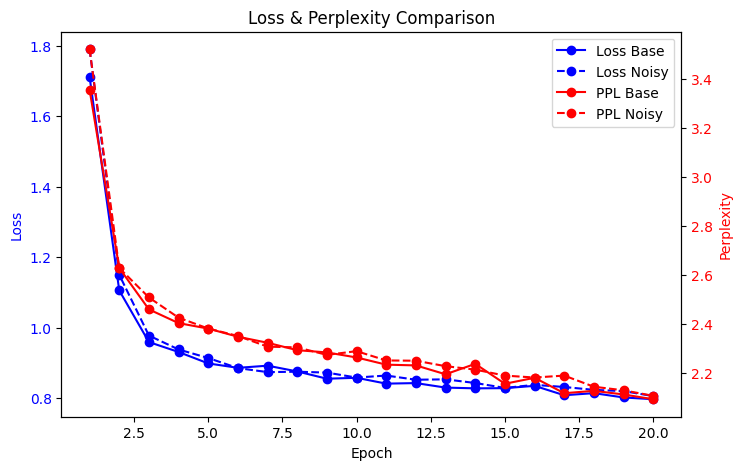

In [35]:
import matplotlib.pyplot as plt

epochs = range(1, len(loss_base)+1)

fig, ax1 = plt.subplots(figsize=(8,5))

# ===== Loss =====
ax1.plot(epochs, loss_base, 'b-o', label='Loss Base')
ax1.plot(epochs, loss_noisy, 'b--o', label='Loss Noisy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# ===== PPL =====
ax2 = ax1.twinx()  # создаем вторую ось Y
ax2.plot(epochs, ppl_base, 'r-o', label='PPL Base')
ax2.plot(epochs, ppl_noisy, 'r--o', label='PPL Noisy')
ax2.set_ylabel('Perplexity', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# ===== легенда =====
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title("Loss & Perplexity Comparison")
plt.show()

Обе модели демонстрируют сходимость — loss и perplexity последовательно снижаются. Из-за компактной архитектуры и непродолжительного обучения конечные метрики оказываются близкими. Поэтому фокус анализа смещается на распределение нагрузки между экспертами

/tmp/ipython-input-3671181548.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


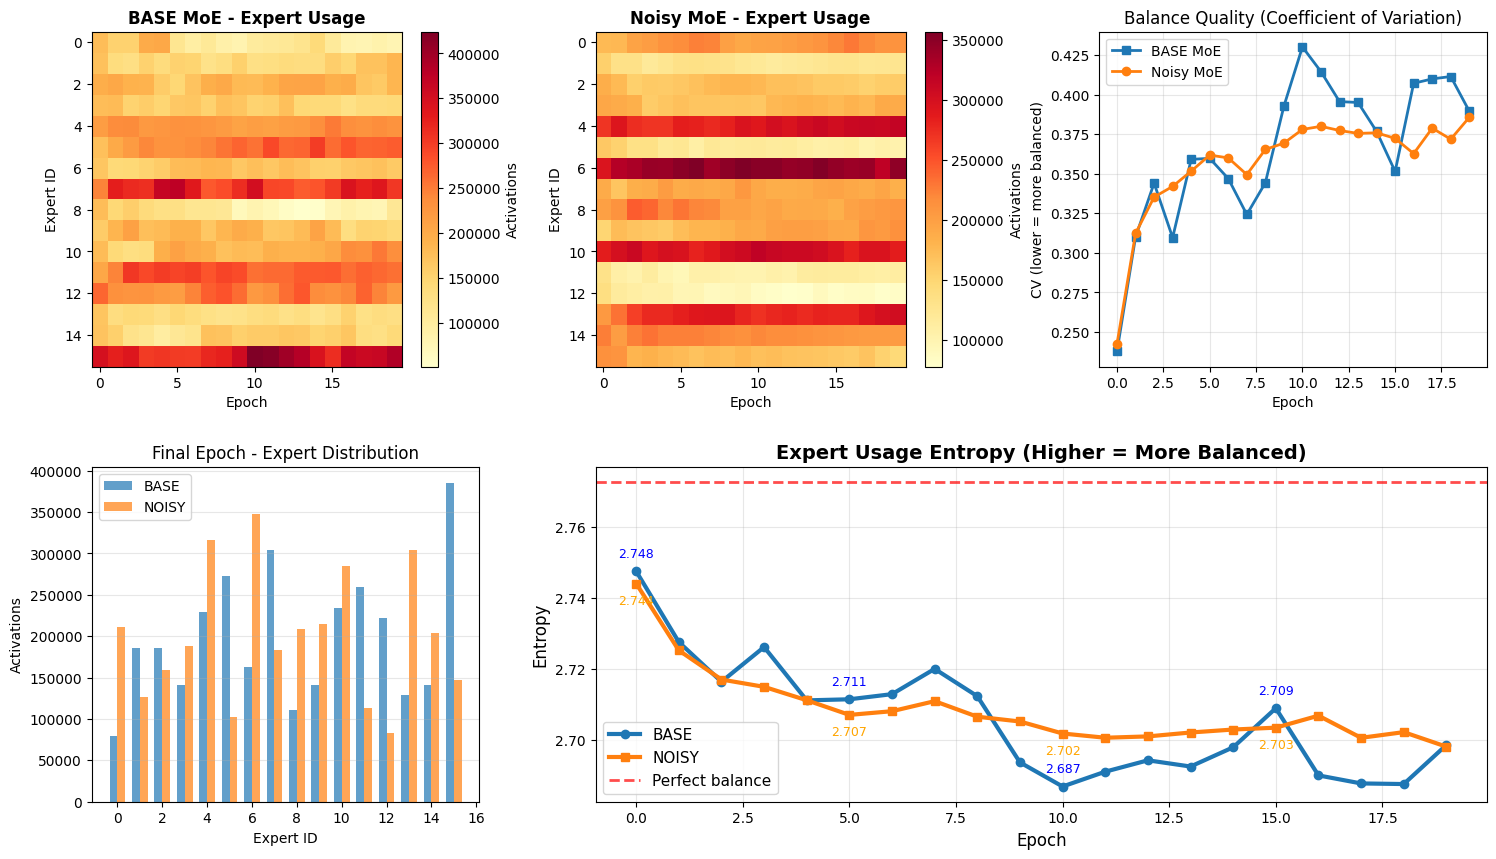

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Преобразуем списки в numpy массивы
usage_base_array = np.array(usage_base)
usage_noisy_array = np.array(usage_noisy)

# Создаем сетку 2x3, но для последнего графика создаем отдельную ось через GridSpec
fig = plt.figure(figsize=(18, 10))
gs = plt.GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)

# 1. Heatmap BASE MoE
ax1 = fig.add_subplot(gs[0, 0])
im = ax1.imshow(usage_base_array.T, aspect='auto', cmap='YlOrRd')
ax1.set_title("BASE MoE - Expert Usage", fontsize=12, fontweight='bold')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Expert ID")
plt.colorbar(im, ax=ax1, label='Activations')

# 2. Heatmap Noisy MoE
ax2 = fig.add_subplot(gs[0, 1])
im = ax2.imshow(usage_noisy_array.T, aspect='auto', cmap='YlOrRd')
ax2.set_title("Noisy MoE - Expert Usage", fontsize=12, fontweight='bold')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Expert ID")
plt.colorbar(im, ax=ax2, label='Activations')

# 3. Коэффициент вариации
ax3 = fig.add_subplot(gs[0, 2])
epochs = range(len(usage_base_array))

# Вычисляем коэффициент вариации для каждой эпохи
cv_base = usage_base_array.std(axis=1) / (usage_base_array.mean(axis=1) + 1e-8)
cv_noisy = usage_noisy_array.std(axis=1) / (usage_noisy_array.mean(axis=1) + 1e-8)

ax3.plot(epochs, cv_base, label='BASE MoE', linewidth=2, marker='s')
ax3.plot(epochs, cv_noisy, label='Noisy MoE', linewidth=2, marker='o')
ax3.set_title("Balance Quality (Coefficient of Variation)", fontsize=12)
ax3.set_xlabel("Epoch")
ax3.set_ylabel("CV (lower = more balanced)")
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Распределение использования на последней эпохе
ax4 = fig.add_subplot(gs[1, 0])
last_base = usage_base_array[-1]
last_noisy = usage_noisy_array[-1]
experts = np.arange(len(last_base))

width = 0.35
ax4.bar(experts - width/2, last_base, width, label='BASE', alpha=0.7)
ax4.bar(experts + width/2, last_noisy, width, label='NOISY', alpha=0.7)
ax4.set_title("Final Epoch - Expert Distribution", fontsize=12)
ax4.set_xlabel("Expert ID")
ax4.set_ylabel("Activations")
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# 5. Энтропия использования (занимает два места в сетке)
ax5 = fig.add_subplot(gs[1, 1:])  # Занимает последние две ячейки в нижнем ряду

def compute_entropy(usage_row):
    probs = usage_row / usage_row.sum()
    # Избегаем log(0)
    probs = probs[probs > 0]
    return -np.sum(probs * np.log(probs))

entropy_base = np.array([compute_entropy(row) for row in usage_base_array])
entropy_noisy = np.array([compute_entropy(row) for row in usage_noisy_array])
max_entropy = np.log(len(usage_base_array[0]))  # максимальная энтропия

ax5.plot(range(len(entropy_base)), entropy_base, label='BASE',
                linewidth=3, marker='o', markersize=6)
ax5.plot(range(len(entropy_noisy)), entropy_noisy, label='NOISY',
                linewidth=3, marker='s', markersize=6)
ax5.axhline(y=max_entropy, color='r', linestyle='--',
                   alpha=0.7, linewidth=2, label=f'Perfect balance')

ax5.set_title("Expert Usage Entropy (Higher = More Balanced)",
                     fontsize=14, fontweight='bold')
ax5.set_xlabel("Epoch", fontsize=12)
ax5.set_ylabel("Entropy", fontsize=12)
ax5.legend(fontsize=11)
ax5.grid(True, alpha=0.3)

# Добавляем аннотации с численными значениями
for i, (eb, en) in enumerate(zip(entropy_base, entropy_noisy)):
    if i % max(1, len(entropy_base) // 4) == 0:  # 4 аннотации равномерно
        ax5.annotate(f'{eb:.3f}', xy=(i, eb), xytext=(0, 10),
                           textcoords='offset points', fontsize=9,
                           color='blue', ha='center')
        ax5.annotate(f'{en:.3f}', xy=(i, en), xytext=(0, -15),
                           textcoords='offset points', fontsize=9,
                           color='orange', ha='center')

plt.tight_layout()
plt.show()

Из результатов анализа следует, что модель с **Noisy Top-K Gating** демонстрирует более равномерное распределение нагрузки между экспертами, в отличие от базового подхода, который склонен к концентрации активаций на ограниченном подмножестве экспертов. Это свидетельствует о лучшей сбалансированности вычислительной нагрузки. Учитывая данное преимущество, для дальнейших экспериментов был выбран механизм Noisy Top-K Gating.

In [40]:
def model_memory_size(model, input_dtype=torch.float32):
    total_params = 0
    total_grads = 0
    for param in model.parameters():
        # Calculate total number of elements per parameter
        param_size = param.numel()
        total_params += param_size
        # Check if gradients are stored for this parameter
        if param.requires_grad:
            total_grads += param_size

    # Calculate buffer size (non-parameters that require memory)
    total_buffers = sum(buf.numel() for buf in model.buffers())

    # Size in bytes = (Number of elements) * (Size of each element in bytes)
    # We assume parameters and gradients are stored in the same type as input dtype
    element_size = torch.tensor(0, dtype=input_dtype).element_size()
    total_memory_bytes = (total_params + total_grads + total_buffers) * element_size

    # Convert bytes to megabytes
    total_memory_mb = total_memory_bytes / (1024**2)

    return total_memory_mb

print(f"float32 (PyTorch default): {model_memory_size(model_noisy, input_dtype=torch.float32):.4f} MB")
print(f"bfloat16: {model_memory_size(model_noisy, input_dtype=torch.bfloat16):.4f} MB")

float32 (PyTorch default): 36.6521 MB
bfloat16: 18.3260 MB


# TEST MODEL

In [41]:
def generate(
    model: nn.Module,
    text_input: str,
    tokenizer: CharTokenizer,
    max_steps: int = 100,
    device: str = "cuda",
) -> str:
    model = model.to(device)
    x = tokenizer.tokenize_ids(text_input)[:-1]
    x_cpu = torch.tensor(x, dtype=torch.int32).unsqueeze(0)
    x_device = x_cpu.to(device)
    generated_tokens = []
    for _ in range(max_steps):
        with torch.no_grad():
            logits = model(x_device)
            probs = F.softmax(logits[0][-1], dim=-1)
            next_x = torch.multinomial(probs, 1).item()

        if next_x == 4:
            break
        gen = torch.tensor([next_x], dtype=torch.int32).unsqueeze(0).to(device)
        x_device = torch.concat((x_device, gen), dim=-1)
        generated_tokens.append(next_x)
    return tokenizer.decode(x + generated_tokens)

In [42]:
model_noisy.eval()

Transformer(
  (_decoder): Decoder(
    (_embeddings): Embedding(77, 64, padding_idx=0)
    (_positional_embedding): RotaryPositionEmbedding()
    (_layers): ModuleList(
      (0-5): 6 x DecoderLayer(
        (_mha): GroupedQueryAttention(
          (_positional_embedding): RotaryPositionEmbedding()
          (_Q): Linear(in_features=64, out_features=64, bias=True)
          (_K): Linear(in_features=64, out_features=16, bias=True)
          (_V): Linear(in_features=64, out_features=16, bias=True)
          (_W_proj): Linear(in_features=64, out_features=64, bias=True)
          (_q_norm): RMSNorm()
          (_k_norm): RMSNorm()
        )
        (_fcnn): MoENoisyTopKGateFeedForward(
          (_gate): Linear(in_features=64, out_features=16, bias=False)
          (_noise_linear): Linear(in_features=64, out_features=16, bias=False)
          (_fc1): ModuleList(
            (0-15): 16 x Linear(in_features=64, out_features=256, bias=False)
          )
          (_fc2): ModuleList(
        

In [43]:
generate(
    model=model_noisy,
    text_input="Красотка",
    tokenizer=tokenizer,
    device=device,
)

'Красотканина Мерликова'